# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [1]:
from thick_ptycho.simulation.config import SimulationConfig, ProbeType, ProbeConfig
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.forward_model.pwe.operators import BoundaryType
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import PWEIterativeLUSolver
from matplotlib import pyplot as plt
import time


import numpy as np

### Simulated Probe Configuration

In [ ]:
probe_config = ProbeConfig(
    type=ProbeType.AIRY_DISK,
    wave_length=0.635e-6,  # meters (0.635 μm). Visible light
    diameter=5e-6,  # [m]
    focus=-3e-6,  # focal length [m]
    # tilts=(np.linspace(-15,15,3)) # tilts in degrees
)

Probe options:
 - constant
 - gaussian
 - sinusoidal
 - complex_exp
 - dirichlet_test
 - neumann_test
 - airy_disk
 - disk
 - blurred_disk


### Discretization Parameters and Spatial Limits

In [ ]:
# Width Discretization (Pixels)
scan_points = 50
step_size_px = 20
pad_factor = 2.0  # Must be >= 1.0
# Overlap = N - (scan_points*step_size_px) = padding
# Overlap factor = (N - (scan_points*step_size_px)) / step_size_px
#                = (pad_factor*scan_points) - scan_points) = scan_points*(pad_factor - 1)
# N = int(pad_factor*scan_points*step_size_px)
solve_reduced_domain = True

# Thickness Discretization (Pixels)
points_per_wavelength = 8
# Then:
#  - dz = wavelength / points_per_wavelength
#  - nz = int((zlims[1] - zlims[0]) / dz)
# Override by setting nz directly


# --- Simulation spatial dimensions (in meters) ---
spatial_limits = Limits(
    x=(0.0, 150e-6),  # Sample width
    z=(0.0, 40e-6),  # Sample thickness
    units="meters",
)

### Simulation Config

2025-12-03 10:29:04,575 - INFO - === Scan Summary (Continuous) ===
2025-12-03 10:29:04,577 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-03 10:29:04,580 - INFO -   Sample space (z-range): 4.000e-05 m
2025-12-03 10:29:04,583 - INFO -   Sample Pixels:          2001
2025-12-03 10:29:04,588 - INFO -   Number of scan points:  50
2025-12-03 10:29:04,593 - INFO -   Steps in z:             503
2025-12-03 10:29:04,595 - INFO -   Solve reduced domain:   1020 px
2025-12-03 10:29:04,599 - INFO -   Probe diameter:         5.000e-06 m
2025-12-03 10:29:04,601 - INFO -   Probe Pixels:          66 px
2025-12-03 10:29:04,605 - INFO -   Max Overlap:            3.500e-06 m
2025-12-03 10:29:04,609 - INFO -   Percentage Overlap:     70.00%



Padding/Overlap: 1001


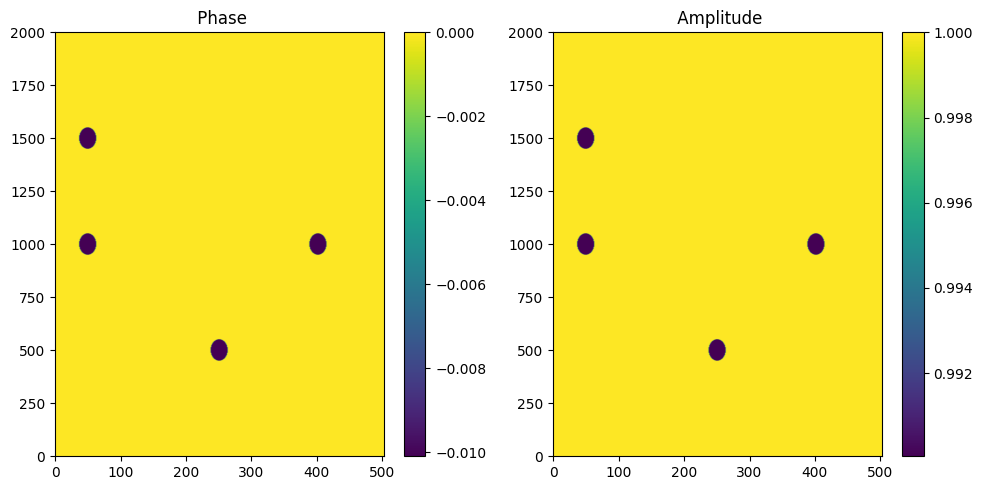

In [ ]:
# --- Create the SimulationConfig object ---
# Defines scan path, probe parameters, discretization,
# object domain.
# Solver parameters are defined in the solver classes.
sim_config = SimulationConfig(
    probe_config=probe_config,
    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=solve_reduced_domain,
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=1.0,  # 1.0 for free space
    # Logging and results
    results_dir="./results",
    use_logging=True,
)

# --- Create the simulation space ---
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()
print("Padding/Overlap:", simulation_space.nx - simulation_space.min_nx)

# --- Create a Simultated Ptycho Object ---
ptycho_object = create_ptycho_object(simulation_space)


# Add 6 spheres of varying positions
# Base refractive index offsets
delta = 0.01  # real part (phase shift)
beta = 0.01  # complex part (absorption)

gaussian_blur = 0.5
common_side_length_factor = 0.05
common_depth_factor = 0.05

refractive_index_perturbation = complex(real=-delta, imag=-beta)
ptycho_object.add_object(
    "circle",
    refractive_index_perturbation,
    side_length_factor=common_side_length_factor,
    centre_factor=(0.5, 0.1),  # normalized coordinates
    depth_factor=common_depth_factor,
    gaussian_blur=gaussian_blur,
)
ptycho_object.add_object(
    "circle",
    refractive_index_perturbation,
    side_length_factor=common_side_length_factor,
    centre_factor=(0.5, 0.8),  # normalized coordinates
    depth_factor=common_depth_factor,
    gaussian_blur=gaussian_blur,
)
ptycho_object.add_object(
    "circle",
    refractive_index_perturbation,
    side_length_factor=common_side_length_factor,
    centre_factor=(0.25, 0.5),  # normalized coordinates
    depth_factor=common_depth_factor,
    gaussian_blur=gaussian_blur,
)
ptycho_object.add_object(
    "circle",
    refractive_index_perturbation,
    side_length_factor=common_side_length_factor,
    centre_factor=(0.75, 0.1),  # normalized coordinates
    depth_factor=common_depth_factor,
    gaussian_blur=gaussian_blur,
)

ptycho_object.build_field()

# --- Visualize the True Object ---
simulation_space.viewer.plot_two_panels(
    ptycho_object.refractive_index, view="phase_amp"
)


# --- Create a set of Simulated Ptycho Probes ---
ptycho_probes = create_ptycho_probes(simulation_space)

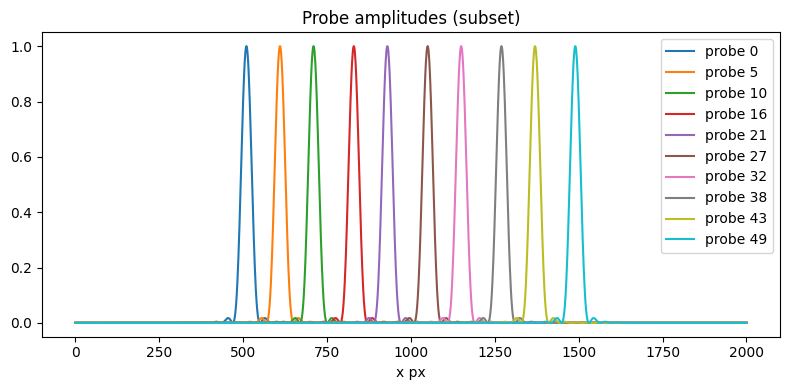

In [5]:
# Full scan view
sim_config_full = SimulationConfig(
    # Probe parameters
    probe_config=probe_config,
    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=False,
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=1.0,  # 1.0 for free space
    # Logging and results
    results_dir="./results",
    use_logging=True,
)
simulation_space_full = create_simulation_space(sim_config_full)
# --- Create a set of Simulated Ptycho Probes ---
ptycho_probes_full = create_ptycho_probes(simulation_space_full)

plt.figure(figsize=(8, 4))
plot_num_probes = min(10, simulation_space.total_scans)  # simulation_space.num_probes
probe_indices = np.linspace(
    0, simulation_space.total_scans - 1, plot_num_probes, dtype=int
)

ptycho_probes_full_flat = ptycho_probes_full.reshape(
    (simulation_space_full.total_scans, *simulation_space_full.effective_shape[:-1])
)
for p in probe_indices:
    plt.plot(
        range(simulation_space_full.effective_nx),
        np.abs(ptycho_probes_full_flat[p, :]),
        label=f"probe {p}",
    )
plt.title("Probe amplitudes (subset)")
plt.xlabel("x px")
plt.legend()
plt.tight_layout()
plt.show()

### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [6]:
# Solve Full Space Space, Iterative
# --- Enumerated configuration types ---
bc_type = BoundaryType.IMPEDANCE

# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe = PWEIterativeLUSolver(
    simulation_space, ptycho_probes, bc_type=bc_type
)


# Iterative solution
u_pwe = forward_model_pwe.solve(n=ptycho_object.refractive_index)
time_end = time.time()
print(
    f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n"
)
exit_waves_pwe = forward_model_pwe.get_exit_waves(u_pwe)
intensities_pwe_noisy = forward_model_pwe.get_farfield_intensities(
    exit_waves=exit_waves_pwe, poisson_noise=True
)
intensities_pwe = forward_model_pwe.get_farfield_intensities(
    exit_waves=exit_waves_pwe, poisson_noise=False
)

Forward model creation and solving time: 71.90 seconds.



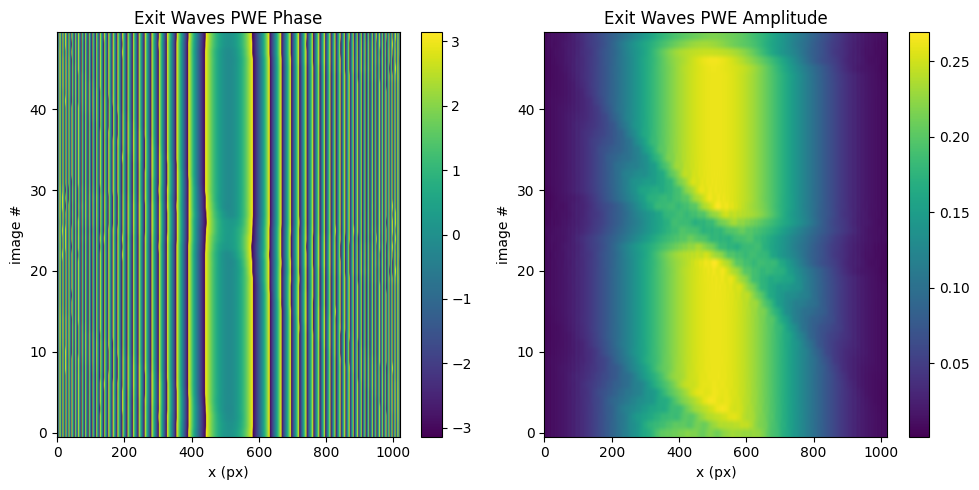

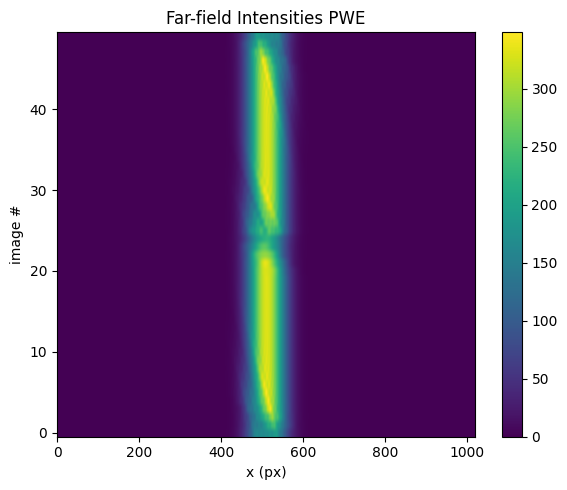

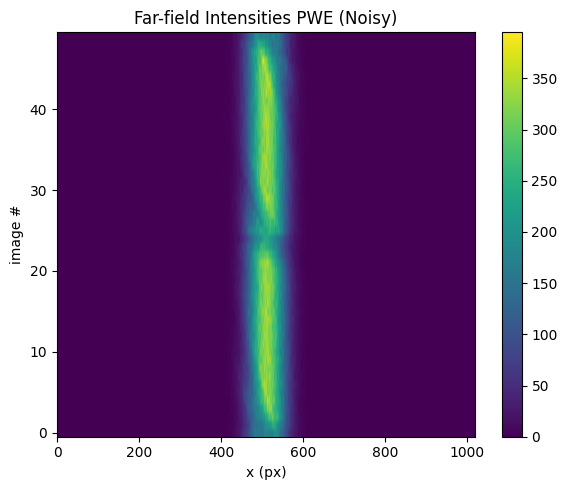

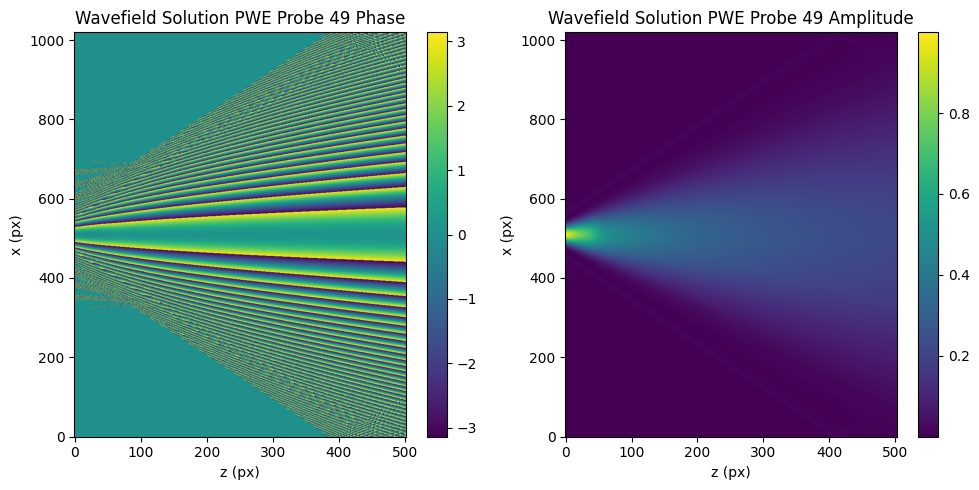

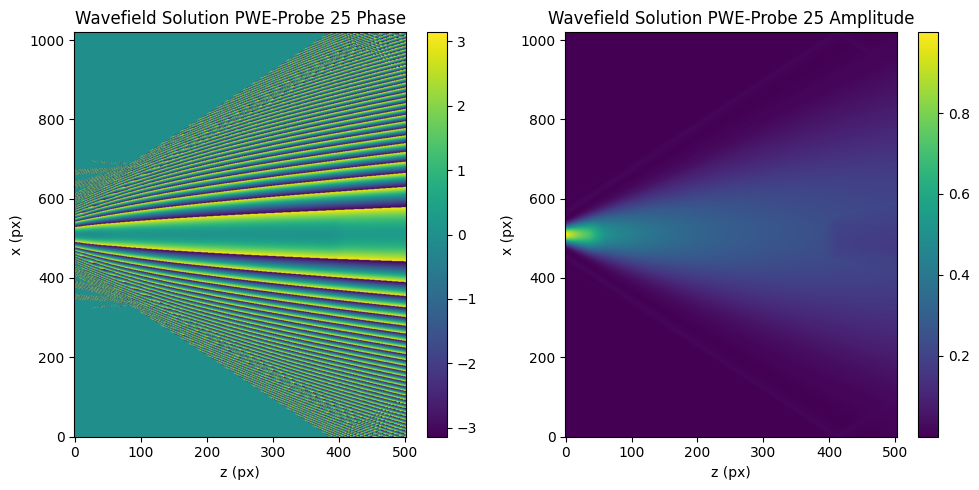

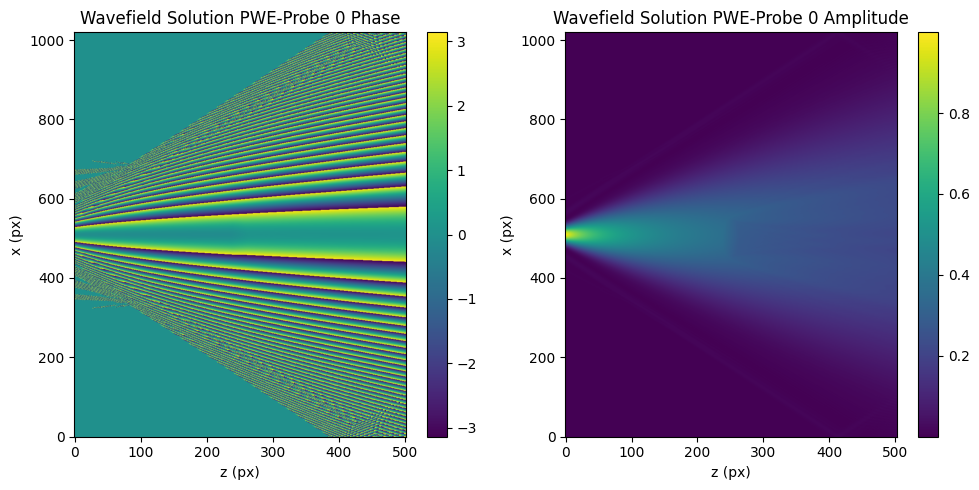

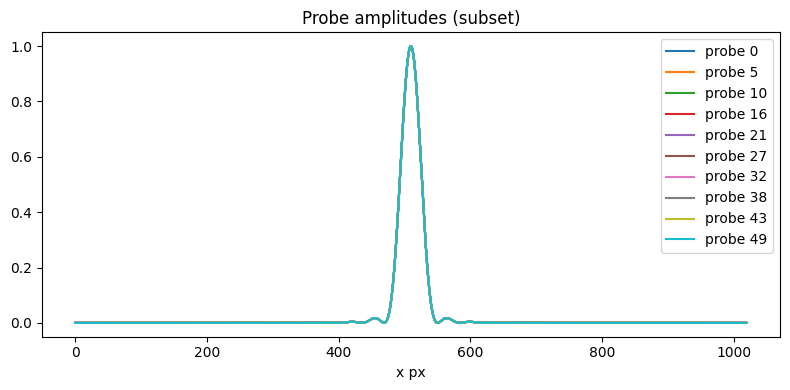

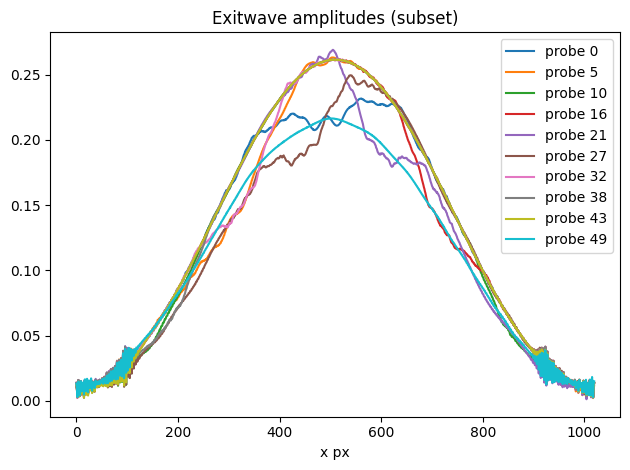

In [7]:
simulation_space.viewer.plot_two_panels(
    exit_waves_pwe,
    view="phase_amp",
    title="Exit Waves PWE",
    xlabel="x (px)",
    ylabel="image #",
)

simulation_space.viewer.plot_single_panel(
    np.fft.fftshift(intensities_pwe),
    title="Far-field Intensities PWE",
    xlabel="x (px)",
    ylabel="image #",
)

simulation_space.viewer.plot_single_panel(
    np.fft.fftshift(intensities_pwe_noisy),
    title="Far-field Intensities PWE (Noisy)",
    xlabel="x (px)",
    ylabel="image #",
)

# Select Centre Probe
simulation_space.viewer.plot_two_panels(
    u_pwe[
        simulation_space.num_projections // 2, simulation_space.num_angles // 2, -1, ...
    ],
    view="phase_amp",
    title=f"Wavefield Solution PWE Probe {simulation_space.num_probes - 1}",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_two_panels(
    u_pwe[
        simulation_space.num_projections // 2,
        simulation_space.num_angles // 2,
        simulation_space.num_probes // 2,
        ...,
    ],
    view="phase_amp",
    title=f"Wavefield Solution PWE-Probe {simulation_space.num_probes // 2}",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_two_panels(
    u_pwe[
        simulation_space.num_projections // 2, simulation_space.num_angles // 2, 0, ...
    ],
    view="phase_amp",
    title=f"Wavefield Solution PWE-Probe {0}",
    xlabel="z (px)",
    ylabel="x (px)",
)

# plt.plot(range(simulation_space.effective_nx), u_pwe[0,0,simulation_space.num_probes//2, :, simulation_space.nz//2])
# plt.show()

plt.figure(figsize=(8, 4))
plot_num_probes = min(10, simulation_space.total_scans)  # simulation_space.num_probes
probe_indices = np.linspace(
    0, simulation_space.total_scans - 1, plot_num_probes, dtype=int
)

u_pwe_flat = u_pwe.reshape((simulation_space.total_scans, *u_pwe.shape[-2:]))
for p in probe_indices:
    plt.plot(
        range(simulation_space.effective_nx),
        np.abs(u_pwe_flat[p, :, 0]),
        label=f"probe {p}",
    )
plt.title("Probe amplitudes (subset)")
plt.xlabel("x px")
plt.legend()
plt.tight_layout()
plt.show()

for p in probe_indices:
    plt.plot(
        range(simulation_space.effective_nx),
        np.abs(u_pwe_flat[p, :, -1]),
        label=f"probe {p}",
    )
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x px")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe_empty = PWEIterativeLUSolver(
    simulation_space, ptycho_probes, bc_type=bc_type
)

# Iterative solution
u_pwe_empty = forward_model_pwe_empty.solve()
time_end = time.time()
print(
    f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n"
)
exit_waves_pwe_empty = forward_model_pwe_empty.get_exit_waves(u_pwe_empty)
intensities_pwe_noisy_empty = forward_model_pwe_empty.get_farfield_intensities(
    exit_waves=exit_waves_pwe_empty, poisson_noise=True
)
intensities_pwe_empty = forward_model_pwe_empty.get_farfield_intensities(
    exit_waves=exit_waves_pwe_empty, poisson_noise=False
)

Forward model creation and solving time: 66.58 seconds.



Exit wave max abs: 0.2690500240495708
Exit wave max abs empty: 0.2690500240495708
Exit wave max abs error: 0.0


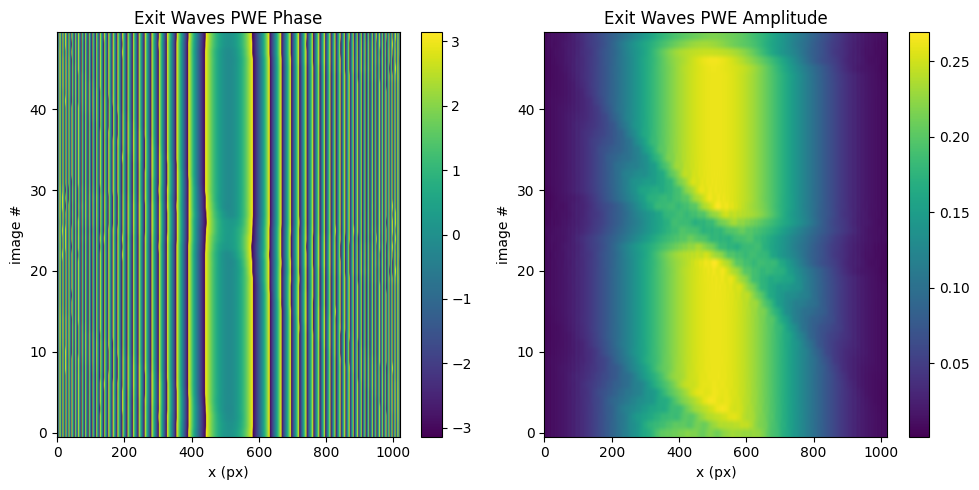

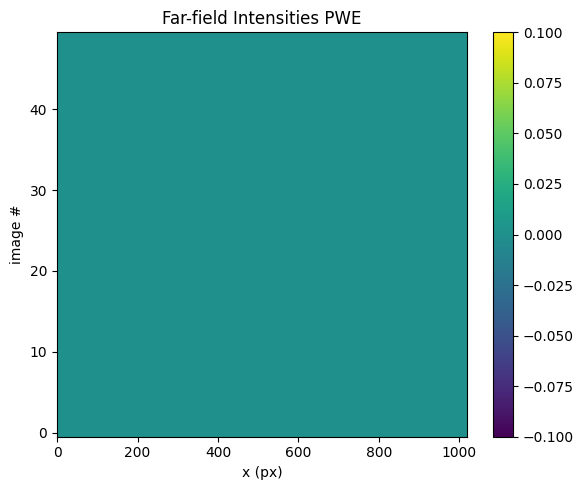

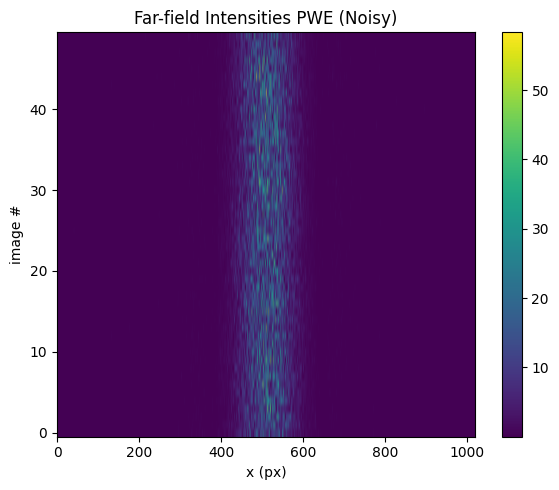

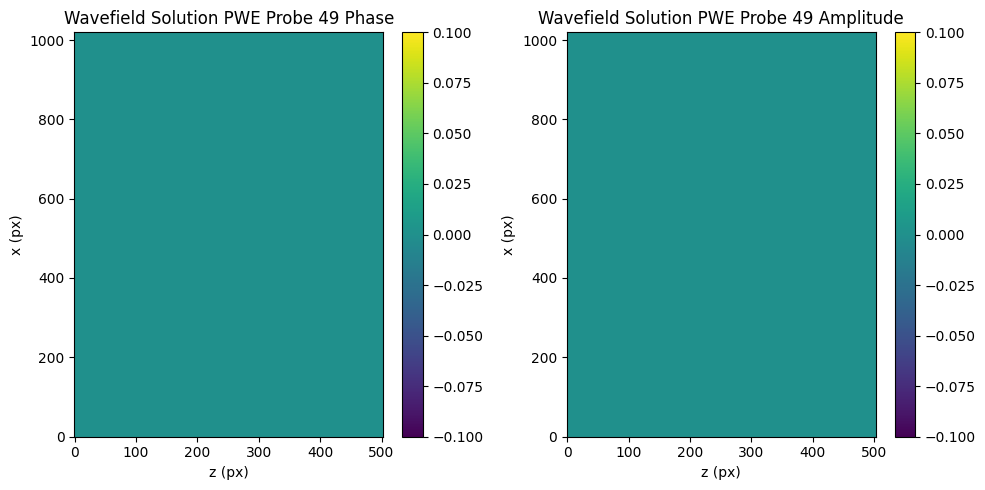

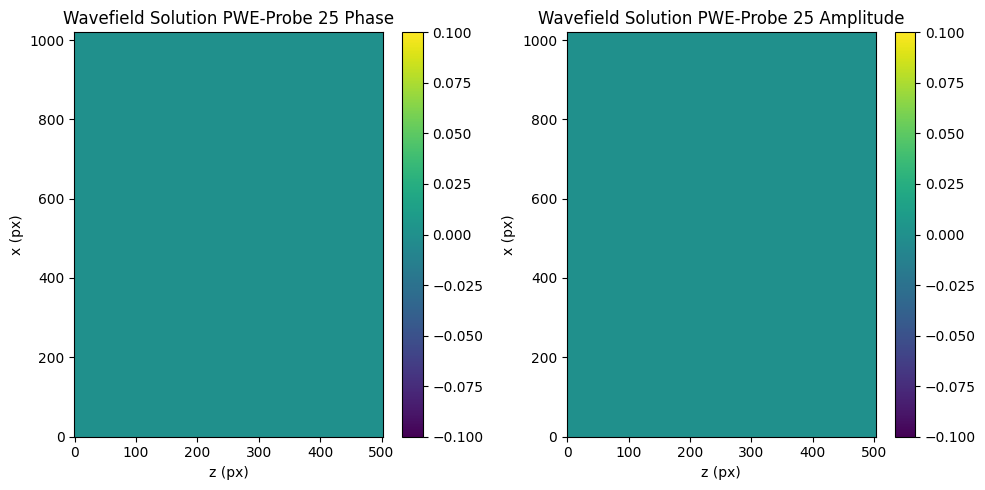

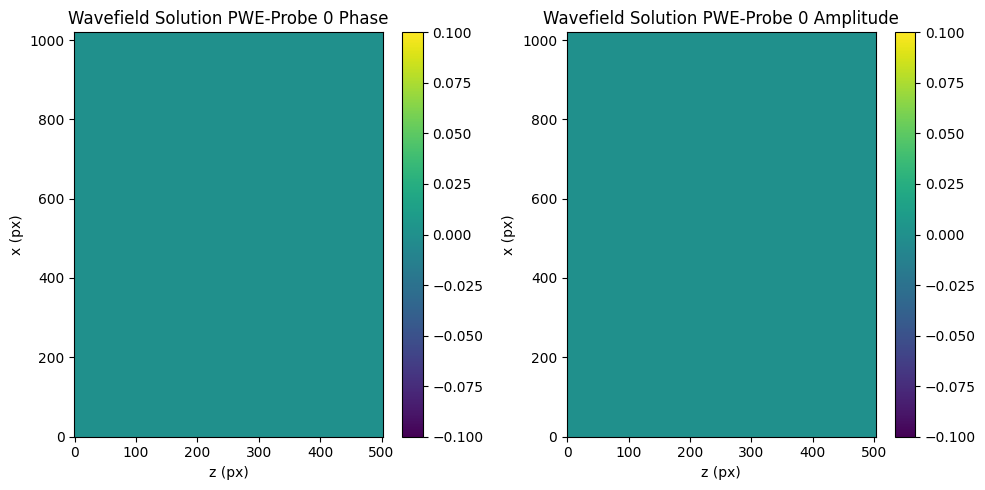

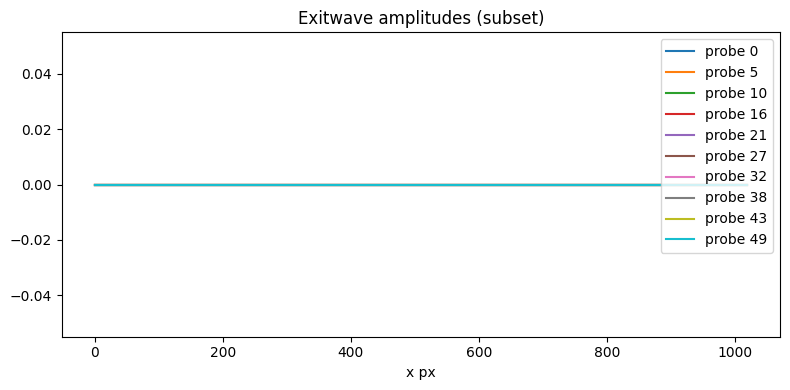

In [13]:
exit_errors = exit_waves_pwe - exit_waves_pwe_empty
print("Exit wave max abs:", np.max(np.abs(exit_waves_pwe)))
print("Exit wave max abs empty:", np.max(np.abs(exit_waves_pwe_empty)))
print("Exit wave max abs error:", np.max(np.abs(exit_errors)))
intensity_errors = intensities_pwe - intensities_pwe_empty
intensity_noisy_errors = intensities_pwe_noisy - intensities_pwe_empty
u_pwe_error = u_pwe - u_pwe_empty
simulation_space.viewer.plot_two_panels(
    exit_waves_pwe_empty,
    view="phase_amp",
    title="Exit Waves PWE",
    xlabel="x (px)",
    ylabel="image #",
)

simulation_space.viewer.plot_single_panel(
    np.fft.fftshift(intensity_errors),
    title="Far-field Intensities PWE",
    xlabel="x (px)",
    ylabel="image #",
)

simulation_space.viewer.plot_single_panel(
    np.fft.fftshift(intensity_noisy_errors),
    title="Far-field Intensities PWE (Noisy)",
    xlabel="x (px)",
    ylabel="image #",
)

# Select Centre Probe
simulation_space.viewer.plot_two_panels(
    u_pwe_error[
        simulation_space.num_projections // 2, simulation_space.num_angles // 2, -1, ...
    ],
    view="phase_amp",
    title=f"Wavefield Solution PWE Probe {simulation_space.num_probes - 1}",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_two_panels(
    u_pwe_error[
        simulation_space.num_projections // 2,
        simulation_space.num_angles // 2,
        simulation_space.num_probes // 2,
        ...,
    ],
    view="phase_amp",
    title=f"Wavefield Solution PWE-Probe {simulation_space.num_probes // 2}",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_two_panels(
    u_pwe_error[
        simulation_space.num_projections // 2, simulation_space.num_angles // 2, 0, ...
    ],
    view="phase_amp",
    title=f"Wavefield Solution PWE-Probe {0}",
    xlabel="z (px)",
    ylabel="x (px)",
)

plt.figure(figsize=(8, 4))
plot_num_probes = min(10, simulation_space.total_scans)  # simulation_space.num_probes
probe_indices = np.linspace(
    0, simulation_space.total_scans - 1, plot_num_probes, dtype=int
)

u_pwe_error_flat = u_pwe_error.reshape(
    (simulation_space.total_scans, *u_pwe_error.shape[-2:])
)
for p in probe_indices:
    plt.plot(
        range(simulation_space.effective_nx),
        np.abs(u_pwe_error_flat[p, :, -1]),
        label=f"probe {p}",
    )
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x px")
plt.legend()
plt.tight_layout()
plt.show()